# ARIMA Anomaly Detection using Monthly Average Daily Temperature Signals from the WD Dataset
This notebook demonstrates the application of the auto_arima() function for detecting anomalies in monthly average daily temperature signals from the Weather Dataset.

The code in this notebook is based on a tutorial from the pmdarima GitHub repository: https://github.com/alkaline-ml/pmdarima/blob/master/examples/stock_market_example.ipynb.


In [1]:
#import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import pmdarima as pm
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from sklearn.metrics import mean_squared_error
from matplotlib.dates import MonthLocator, DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.metrics import smape

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_3287/714932261.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## Data preprocessing
First, read the 'daily_temperature.csv' file from the 'data' folder, and then calculate the average monthly temperature.

In [2]:
# read a 'daily_temperature_Bamberg.csv' data
df = pd.read_csv('data/daily_temperature_Bamberg.csv')

#convert the 'MESS_DATUM' column to a datetime format
df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'])
df.set_index('MESS_DATUM', inplace=True)

#resample the DataFrame by month ('M') and calculate the mean for each month
df = df.resample('M').mean()
df.head()


,TT_TU
MESS_DATUM,
1961-01-31,-0.859032
1961-02-28,3.920000
1961-03-31,5.872581
1961-04-30,12.070000
1961-05-31,10.677742


In [3]:
#reset the index of the DataFrame 'df' and store the result in 'df_monthly_mean'
df_monthly_mean = df.reset_index(drop=False)
df_monthly_mean.head()

,MESS_DATUM,TT_TU
0,1961-01-31,-0.859032
1,1961-02-28,3.920000
2,1961-03-31,5.872581
3,1961-04-30,12.070000
4,1961-05-31,10.677742


Set a new format for the index column as MM-YYYY and save it in a new CSV file.

In [4]:
df_monthly_mean['MESS_DATUM'] = pd.to_datetime(df_monthly_mean['MESS_DATUM'])
df_monthly_mean['Date'] = df_monthly_mean['MESS_DATUM'].dt.strftime('%Y-%m')
df_monthly_mean.drop(columns=['MESS_DATUM'], inplace=True)
df_monthly_mean.set_index('Date', inplace=True)

In [5]:
#store the prepared data in '.csv' format (optional).
df_monthly_mean.to_csv('data/Monthly_temperature_ARIMA.csv',index=True)

## Plots
Create plots of rolling mean and seasonal value decomposition. Create lag plot.## Plot statistical information about monthly average temperature Test signal.


In [8]:
#read 'Monthly_temperature_ARIMA.csv' as DataFrame
df_monthly_mean = pd.read_csv('data/Monthly_temperature_ARIMA.csv',index_col=0)

In [6]:
#define the window size for the rolling mean calculation
window_size = 12  # Set the window size to 12 months

#calculate the rolling mean of the 'P' column
df_monthly_mean['Rolling_Mean'] = df_monthly_mean['TT_TU'].rolling(window=window_size).mean()

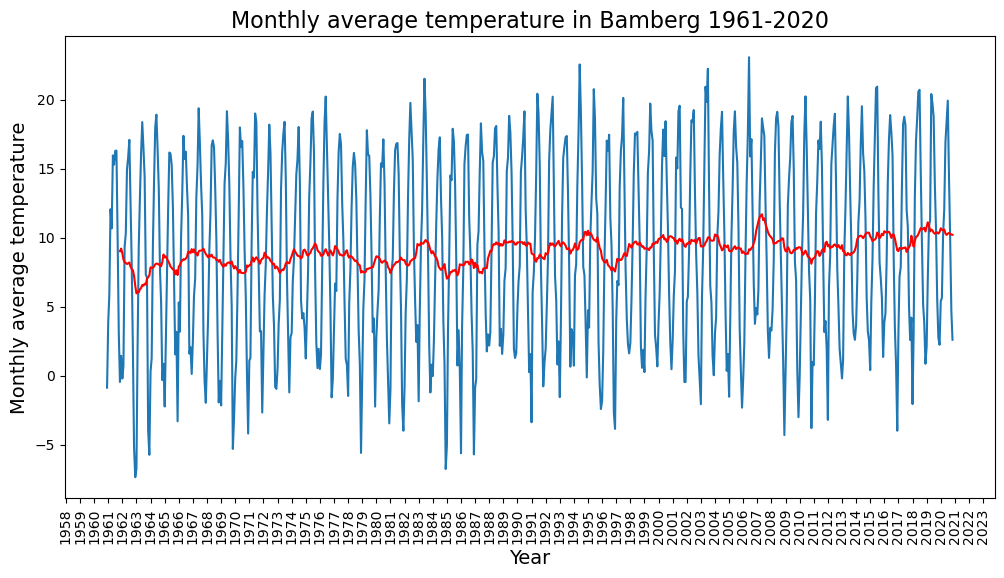

In [7]:
#convert the index of the DataFrame 'df_monthly_mean' to datetime format
df_monthly_mean.index = pd.to_datetime(df_monthly_mean.index)

#plot
plt.figure(figsize=(12, 6))
plt.plot(df_monthly_mean.index, df_monthly_mean['TT_TU'])# plot the Monthly average pressure over time
plt.plot(df_monthly_mean.index, df_monthly_mean['Rolling_Mean'], 
        label=f'Rolling mean (window={window_size})', color='red') #plot the rolling mean
plt.xlabel('Year',size=14)
plt.ylabel('Monthly average temperature',size=14)
plt.title('Monthly average temperature in Bamberg 1961-2020',size=16)


#formatting the date on the x-axis
months = MonthLocator(interval=12)
monthsFmt = DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(months)
plt.gca().xaxis.set_major_formatter(monthsFmt)
plt.xticks(rotation=90)


plt.show()

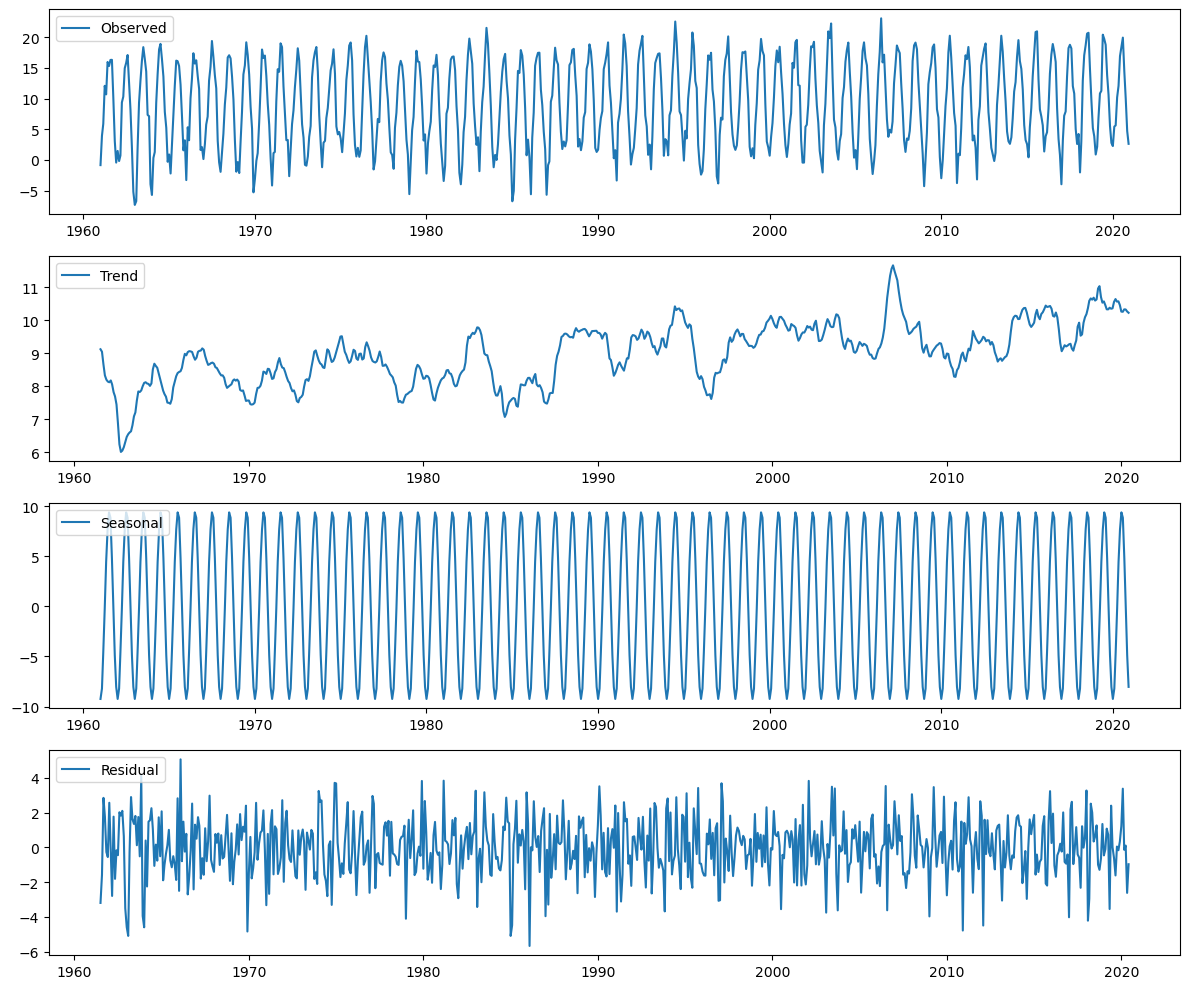

In [8]:
#perform seasonal decomposition with additive model
result = seasonal_decompose(df_monthly_mean['TT_TU'], model='additive', period=12)  #additive model

#for multiplicative model
#add a constant offset to make data non-negative
#offset = abs(min(df_monthly_mean['TT_TU'])) + 1
#df_monthly_mean['adjusted_TT'] = df_monthly_mean['TT_TU'] + offset
#perform seasonal decomposition with multiplicative model
#result = seasonal_decompose(df_monthly_mean['adjusted_TT'], model='multiplicative', period=12)  # Adjust the period as needed

#plot the decomposed components
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

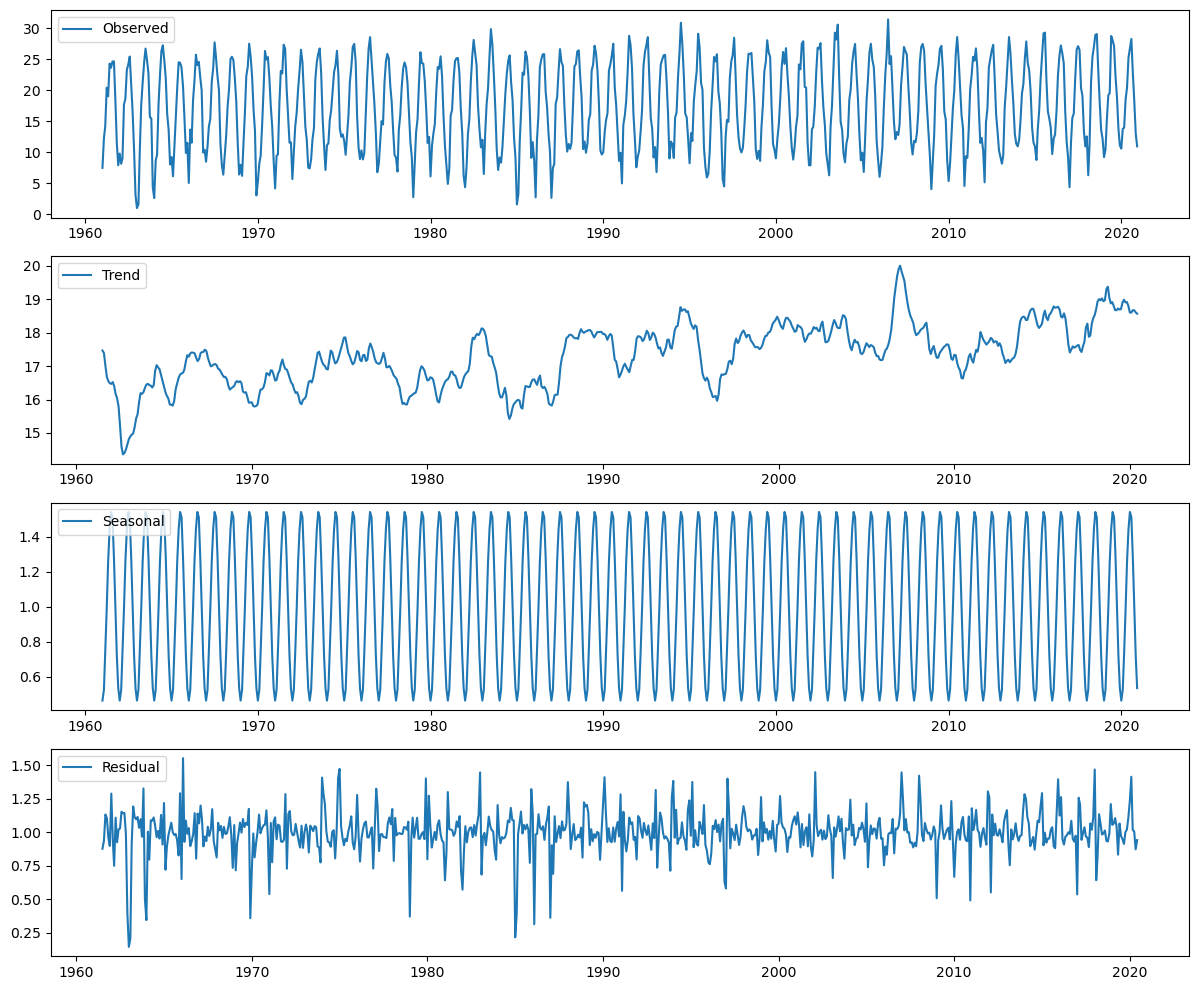

In [39]:
#add a constant offset to make data non-negative
offset = abs(min(df_monthly_mean['TT_TU'])) + 1
df_monthly_mean['adjusted_TT'] = df_monthly_mean['TT_TU'] + offset

#perform seasonal decomposition with multiplicative model
result = seasonal_decompose(df_monthly_mean['adjusted_TT'], model='multiplicative', period=12)  # Adjust the period as needed

#plot the decomposed components
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [9]:
# Generate a summary of df_monthly_mean
df_monthly_mean.describe()

,TT_TU,Rolling_Mean
count,720.000000,709.000000
mean,8.987897,8.977491
std,6.905899,0.917475
min,-7.347419,5.970697
25%,3.166167,8.305536
50%,8.794258,9.021627
75%,15.349597,9.642843
max,23.078387,11.701924


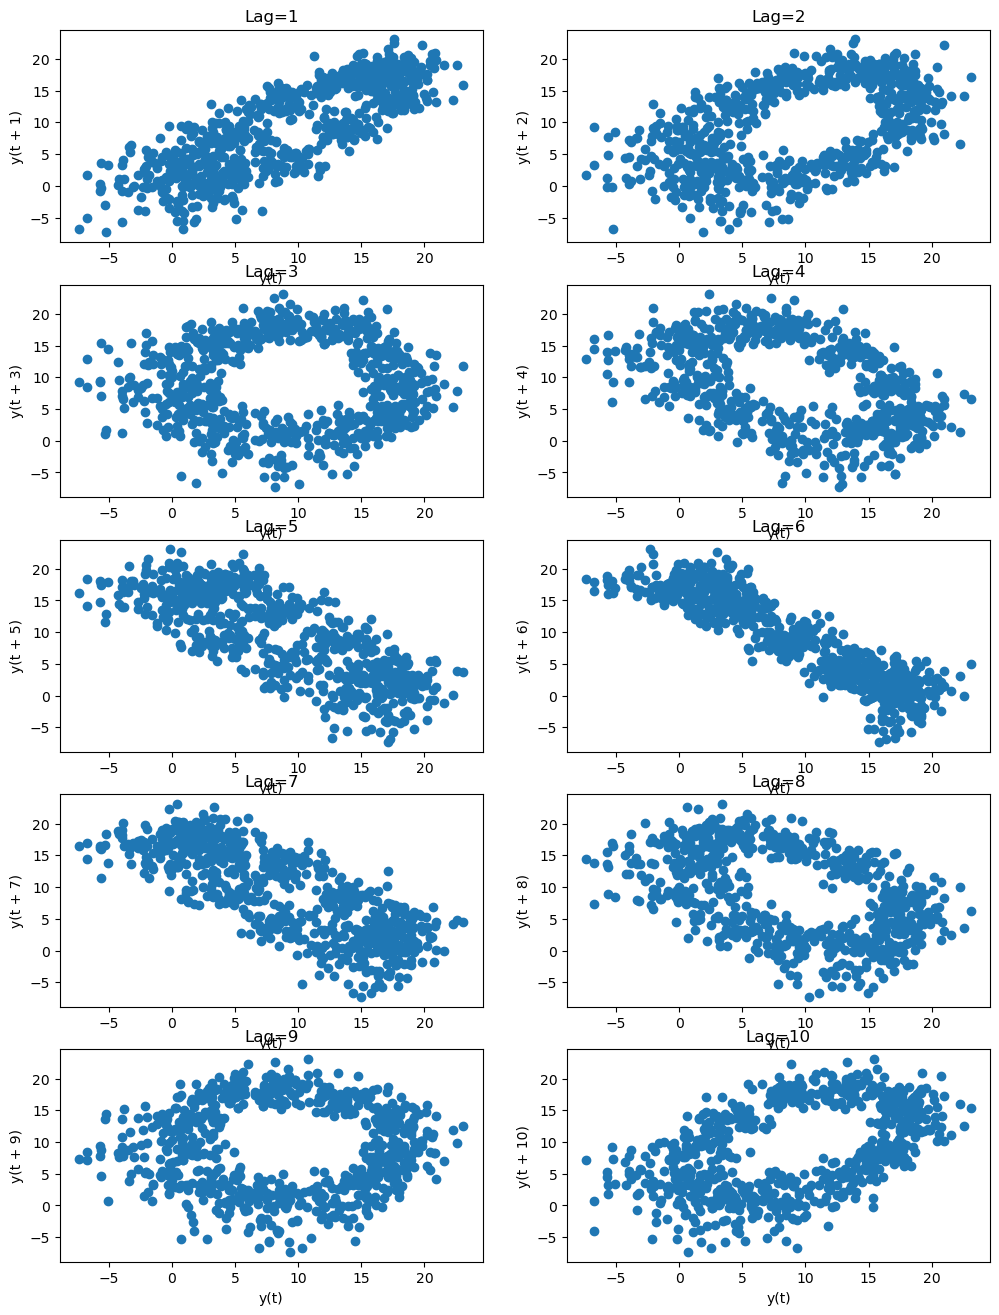

In [10]:
fig, axes = plt.subplots(5, 2, figsize=(12, 16))
plt.title('Autocorrelation plot',size=16)

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1),
    (3,0),
    (3,1),
    (4,0),
    (4,1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(df_monthly_mean['TT_TU'], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")
    
plt.show()

## ARIMA
1. Split the data into training and test sets.
2. Choose the best ARIMA model using pm.auto_arima.
3. Make predictions with the chosen model.
4. Define anomaly points.

In [11]:
#80% refers to training data, 20% refers to test data
#train_len = int(df_monthly_mean.shape[0] * 0.8)
#train_data, test_data = df_monthly_mean[:train_len], df_monthly_mean[train_len:]
#print(f"{train_len} train samples")
#print(f"{df.shape[0] - train_len} test samples")

#values from 1961 to 2000 belong to the training data, and from 2001 to 2020 belong to the test data.
train_data, test_data = df_monthly_mean[df_monthly_mean.index.year <= 2000], df_monthly_mean[df_monthly_mean.index.year > 2000]
y_train = train_data['TT_TU'].values
y_test = test_data['TT_TU'].values
print(f"{len(y_train)} train samples")
print(f"{df.shape[0] - len(y_train)} test samples")

480 train samples
240 test samples


In [12]:
#set seasonal to True
seasonal = True

#use pmdarima to automatically select best ARIMA model
model = pm.auto_arima(y_train, 
                      m=12,               # frequency of series                      
                      seasonal=seasonal,  # TRUE if seasonal series
                      d=None,             # let model determine 'd'
                      test='adf',         # use adftest to find optimal 'd'
                      start_p=0, start_q=0, # minimum p and q
                      max_p=12, max_q=12, # maximum p and q
                      D=None,             # let model determine 'D'
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# print model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=2063.765, Time=1.04 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3222.164, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2643.889, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3671.468, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=2839.467, Time=0.18 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=2062.570, Time=3.02 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=2651.507, Time=0.71 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=4.03 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=4.62 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=6.40 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=6.18 sec
 ARIMA(0,0,0)(1,0,2)[12]             : AIC=inf, Time=2.

In [28]:
# set seasonal to False
seasonal = False

# use pmdarima to automatically select best ARIMA model
model_ns = pm.auto_arima(y_train, 
                      m=12,               # frequency of series                      
                      seasonal=seasonal,  # TRUE if seasonal series
                      d=None,             # let model determine 'd'
                      test='adf',         # use adftest to find optimal 'd'
                      start_p=0, start_q=0, # minimum p and q
                      max_p=12, max_q=12, # maximum p and q
                      D=None,             # let model determine 'D'
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# print model summary
print(model_ns.summary())

/Users/anastasiasinitsyna/anaconda3/lib/python3.10/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3671.468, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2730.325, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3199.308, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2604.856, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=2562.382, Time=0.14 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=2557.456, Time=0.09 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=2499.472, Time=0.12 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=2423.417, Time=0.56 sec
 ARIMA(7,0,0)(0,0,0)[0]             : AIC=2333.702, Time=0.19 sec
 ARIMA(8,0,0)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(7,0,1)(0,0,0)[0]             : AIC=2122.653, Time=1.05 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=2166.975, Time=2.24 sec
 ARIMA(8,0,1)(0,0,0)[0]             : AIC=2103.259, Time=1.09 sec
 ARIMA(9,0,1)(0,0,0)[0]             : AIC=2089.557, Time=1.49 sec
 ARIMA(9,0,0)(0,0,0)[0]             : 

In [13]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
#based on signal properties and AIC of models from previous steps
model = model
#model = model_ns
#define a function for one-step ahead forecasting
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    #use the 'forecast_one_step' function to obtain the forecast and confidence intervals
    fc, conf = forecast_one_step()
    #append the forecast and confidence intervals to their respective lists
    forecasts.append(fc)
    confidence_intervals.append(conf)
    #updates the existing model with a small number of MLE steps
    model.update(new_ob)
    
#calculate Mean Squared Error (MSE) and Symmetric Mean Absolute Percentage Error (SMAPE)
print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")

Mean squared error: 3.387428943720778
SMAPE: 39.83909140803598


In [16]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

#choose a model based on minimal AIC criterion and signal properties
model = model
#model = model_ns

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)
    
    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)
    
print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")

Mean squared error: 3.387428943720778
SMAPE: 39.83909140803598


In [14]:
error = mean_squared_error(y_test, forecasts)
print(error)

3.387428943720778


In [15]:
#add forecast to test data
test_data['forecast'] = forecasts

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_3287/342429525.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['forecast'] = forecasts


In [16]:
test_data.head()

,TT_TU,Rolling_Mean,forecast
Date,,,
2001-01-01,0.471935,10.090808,0.228901
2001-02-01,2.614286,9.992171,1.603787
2001-03-01,5.743226,9.971042,5.075147
2001-04-01,7.572667,9.752847,8.911221
2001-05-01,15.809032,9.798573,13.969845


In [17]:
train_data.head()

,TT_TU,Rolling_Mean
Date,,
1961-01-01,-0.859032,NaN
1961-02-01,3.920000,NaN
1961-03-01,5.872581,NaN
1961-04-01,12.070000,NaN
1961-05-01,10.677742,NaN


In [18]:
#anomaly detection
#calculate the squared error for each data point by subtracting 'forecast' from 'P' and squaring the result
test_data['squared_error'] = np.square(test_data['TT_TU'] - test_data['forecast'])

#calculate the Mean Squared Error (MSE) and Standard Deviation (STD) of squared errors
mean_squared_error = test_data['squared_error'].mean()
std_squared_error = test_data['squared_error'].std()

#set a multiplier 'z'
z = 2.0 

#calculate the threshold value for identifying anomalies
threshold = mean_squared_error + (z * std_squared_error)

#identify anomalies based on squared errors and add an 'is_anomaly' column
test_data['is_anomaly'] = (test_data['squared_error'] >= threshold).astype(int)


/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_3287/2235601826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['squared_error'] = np.square(test_data['TT_TU'] - test_data['forecast'])
/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_3287/2235601826.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['is_anomaly'] = (test_data['squared_error'] >= threshold).astype(int)


In [19]:
print(sum(test_data['is_anomaly']))

15


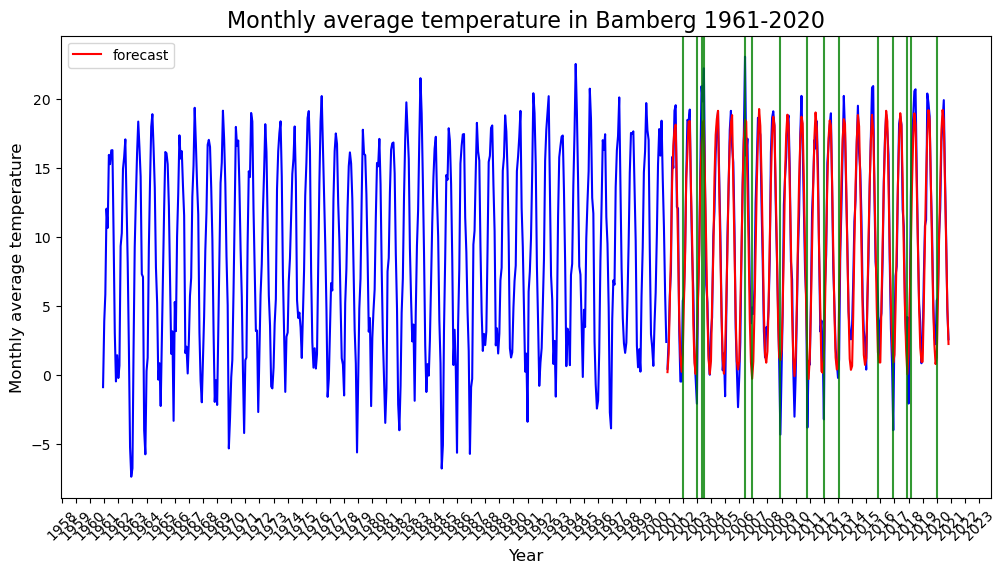

In [20]:
#convert the indices of 'test_data' and 'train_data' DataFrames to datetime format
test_data.index = pd.to_datetime(test_data.index)
train_data.index = pd.to_datetime(train_data.index)


plt.figure(figsize=(12, 6))
#plot the monthly average temperature
plt.plot(train_data.index, train_data['TT_TU'],color='blue')
plt.plot(test_data.index, test_data['TT_TU'],color='blue')
#plot the forecast
plt.plot(test_data.index, test_data['forecast'], label=f'forecast', color='red')

plt.xlabel('Year',size=12)
plt.ylabel('Monthly average temperature',size=12)
plt.title('Monthly average temperature in Bamberg 1961-2020',size=16)

#identify the indices of anomalies
anomaly_indices = test_data.index[test_data['is_anomaly'] == 1]

#create vertical lines for anomaly points, marked in green
for anomaly_index in anomaly_indices:
    plt.axvline(x=anomaly_index, color='green', alpha=0.8)

#formatting the date on the x-axis
months = MonthLocator(interval=12)
monthsFmt = DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(months)
plt.gca().xaxis.set_major_formatter(monthsFmt)

plt.xticks(rotation=45)
plt.legend()
plt.show()

In [21]:
#save results as csv data
test_data.to_csv('data/Monthly_temperature_anomaly_ARIMA_results2001test.csv')

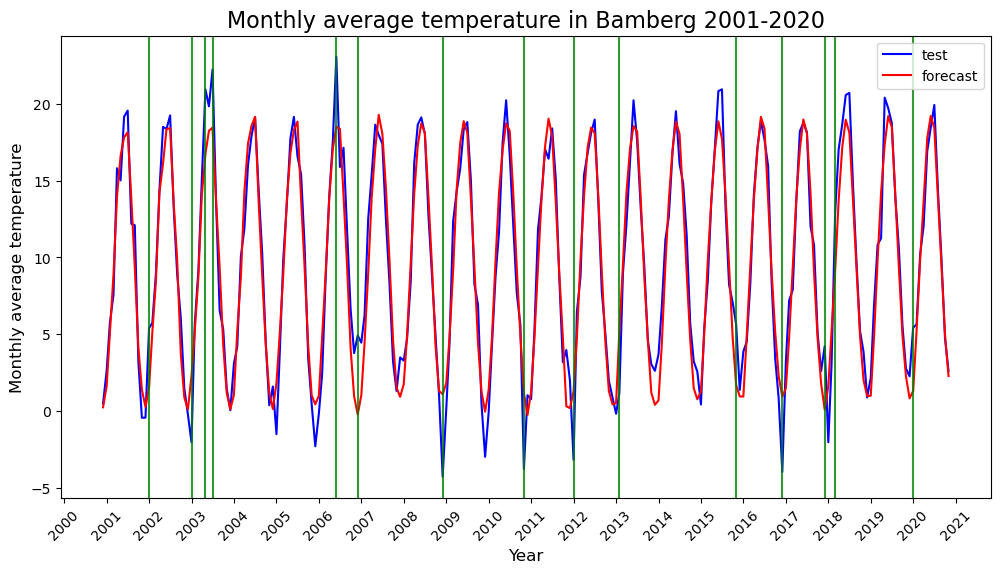

In [22]:
#convert the index of 'train_data' DataFrames to datetime format
test_data.index = pd.to_datetime(test_data.index)

plt.figure(figsize=(12, 6))
#plot the monthly average temperature
plt.plot(test_data.index, test_data['TT_TU'],color='blue', label='test')
#plot the forecast
plt.plot(test_data.index, test_data['forecast'], label='forecast', color='red')
plt.xlabel('Year',size=12)
plt.ylabel('Monthly average temperature',size=12)
plt.title('Monthly average temperature in Bamberg 2001-2020',size=16)

#identify the indices of anomalies
anomaly_indices = test_data.index[test_data['is_anomaly'] == 1]

#create vertical lines for anomaly points, marked in green
for anomaly_index in anomaly_indices:
    plt.axvline(x=anomaly_index, color='green', alpha=0.8)

#formatting the date on the x-axis
months = MonthLocator(interval=12)
monthsFmt = DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(months)
plt.gca().xaxis.set_major_formatter(monthsFmt)

plt.xticks(rotation=45)
plt.legend()
plt.show()

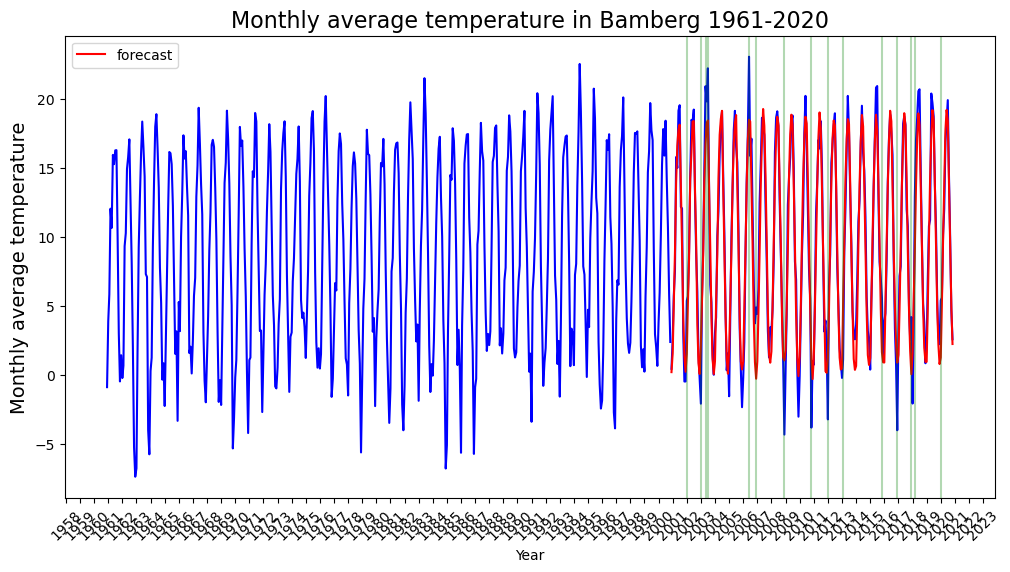

In [23]:
#convert the indices of 'test_data' and 'train_data' DataFrames to datetime format
test_data.index = pd.to_datetime(test_data.index)
train_data.index = pd.to_datetime(train_data.index)


plt.figure(figsize=(12, 6))
#plot the monthly average temperature
plt.plot(train_data.index, train_data['TT_TU'],color='blue')
plt.plot(test_data.index, test_data['TT_TU'],color='blue')
#plot the forecast
plt.plot(test_data.index, test_data['forecast'], label=f'forecast', color='red')

plt.xlabel('Year',size=12)
plt.ylabel('Monthly average temperature',size=12)
plt.title('Monthly average temperature in Bamberg 1961-2020',size=16)

#identify the indices of anomalies
anomaly_indices = test_data.index[test_data['is_anomaly'] == 1]

#create vertical lines for anomaly points, marked in green
for anomaly_index in anomaly_indices:
    plt.axvline(x=anomaly_index, color='green', alpha=0.8)

#formatting the date on the x-axis
months = MonthLocator(interval=12)
monthsFmt = DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(months)
plt.gca().xaxis.set_major_formatter(monthsFmt)

plt.xticks(rotation=45)
plt.legend()
plt.show()

In [53]:
train_data.to_csv('Monthly_temperature_anomaly_ARIMA_results2001test.csv')

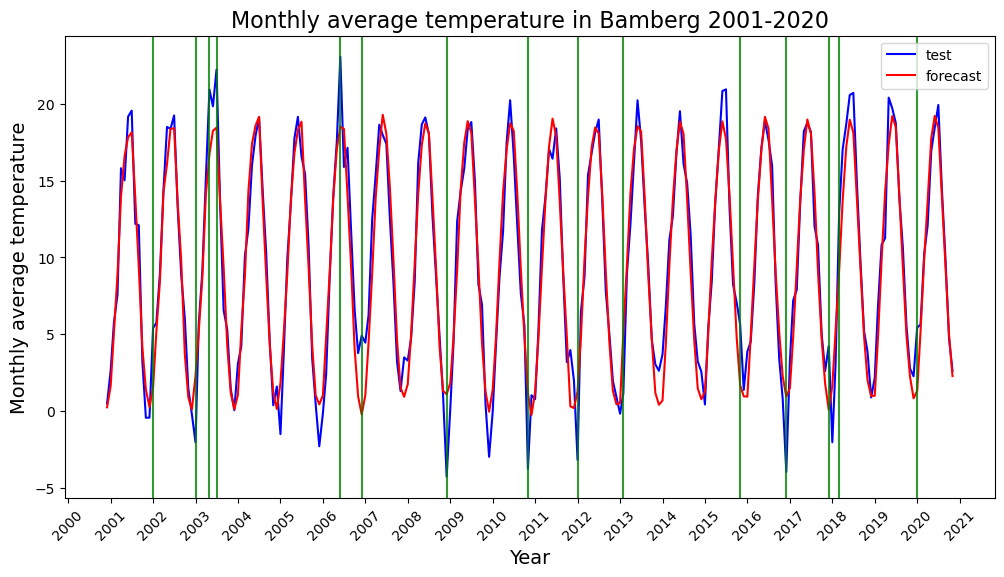

In [25]:
#convert the index of 'train_data' DataFrames to datetime format
test_data.index = pd.to_datetime(test_data.index)

plt.figure(figsize=(12, 6))
#plot the monthly average temperature
plt.plot(test_data.index, test_data['TT_TU'],color='blue', label='test')
#plot the forecast
plt.plot(test_data.index, test_data['forecast'], label='forecast', color='red')
plt.xlabel('Year',size=12)
plt.ylabel('Monthly average temperature',size=12)
plt.title('Monthly average temperature in Bamberg 2001-2020',size=16)

#identify the indices of anomalies
anomaly_indices = test_data.index[test_data['is_anomaly'] == 1]

#create vertical lines for anomaly points, marked in green
for anomaly_index in anomaly_indices:
    plt.axvline(x=anomaly_index, color='green', alpha=0.8)

#formatting the date on the x-axis
months = MonthLocator(interval=12)
monthsFmt = DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(months)
plt.gca().xaxis.set_major_formatter(monthsFmt)

plt.xticks(rotation=45)
plt.legend()
plt.show()

In [56]:
print(test_data[test_data['is_anomaly'] == 1])

                TT_TU  Rolling_Mean  adjusted_TT   forecast  squared_error  \
Date                                                                         
2002-02-01   5.395714      9.571517    13.743134   1.535378      14.902198   
2003-02-01  -2.054643      9.370704     6.292776   2.273679      18.734368   
2003-06-01  20.942000      9.646860    29.289419  16.749096      17.580442   
2003-08-01  22.239355     10.018581    30.586774  18.460245      14.281675   
2006-07-01  23.078387      9.160889    31.425806  18.514408      20.829902   
2007-01-01   4.908710     10.485621    13.256129  -0.247560      26.587118   
2009-01-01  -4.294839      9.289761     4.052581   1.078800      28.875988   
2010-12-01  -3.789355      8.116116     4.558065   1.142739      24.325552   
2012-02-01  -3.194483      9.380879     5.152937   1.259361      19.836727   
2013-03-01   1.150000      9.019094     9.497419   5.080315      15.447376   
2015-12-01   5.627419     10.285660    13.974839   1.666771     